In [195]:
# Importing necessary libraries
import torch
from torch import nn # Foundation for neural networks
import matplotlib.pyplot as plt

# Data

- Create data which follows the formula of linear regression. `y = mx + c`

- Give specific values to the neural network parameters (weight, bias) to later see how well it does. This is obviously because neural network adjusts the `weight` and `bias` to fit the data.

- Splitting the data for train and test sets, no validation set as we won't be validating the training steps.

- Create a function to visualize the data.

In [196]:
# Declaring known parameters

weight = 0.9        # slope (m)
bias = 0.7          # intercept (c)

In [197]:
# Create data
start = 0
end = 50
step = 0.5

X = torch.arange(start = start, end = end, step = step).unsqueeze(dim = 1)
y = weight * X + bias       # y = mx + c

print(len(X), len(y))
print()
print(X[:5])
print()
print(y[:5])

100 100

tensor([[0.0000],
        [0.5000],
        [1.0000],
        [1.5000],
        [2.0000]])

tensor([[0.7000],
        [1.1500],
        [1.6000],
        [2.0500],
        [2.5000]])


In [198]:
# Splitting data to train and test sets
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print("Training Size: " + str(len(X_train)))
print()
print("Testing Size: " + str(len(X_test)))

Training Size: 80

Testing Size: 20


In [199]:
# Function for charting the data
def chart_data(train_data = X_train, 
               train_labels = y_train,
               test_data = X_test,
               test_labels = y_test,
               predictions = None) -> None:
    plt.figure(figsize=(8, 6))
    
    # Training Data
    plt.scatter(train_data, train_labels, c = "r", s = 2, label = "Training data")
    
    # Testing Data
    plt.scatter(test_data, test_labels, c = "g", s = 2, label = "Testing Data")
    
    # Predicitons
    if predictions is None: pass
    else:
        plt.scatter(test_data, predictions, c = "y", s = 2, label = "Predictions")
        
    # Legend
    plt.legend(prop = {"size": 10})

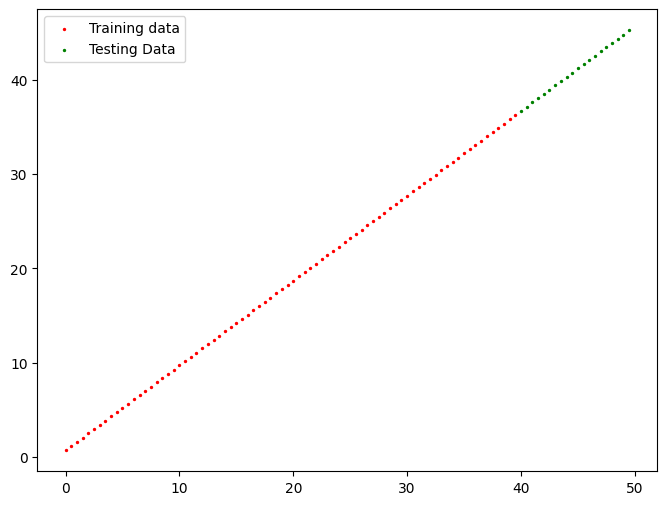

In [200]:
chart_data()

# Model

- Weights, Bias: The parameters of a neural network that is adjusted/changed to fit the patters of the data.

- Forward Pass: Performing the calculations of the neural network from the input layer to the output layer.

- Loss Function: To calculate the error between given data and model's predictions. Moving towards the minima of this function is machine learning.

- Optimizer: Consider the loss and adjust the model's parameters to better fit the patterns of data. Gradient descent.

In [201]:
# Creating a linear regression model
class LinearRegressionModel(nn.Module): # Subclass of nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1)) # randn -> normalized random, general use
        self.bias = nn.Parameter(torch.randn(1))
    
    # Forward pass
    def forward(self, x) -> torch.Tensor:
        return self.weights * x + self.bias

In [202]:
# Creating an instance and checking the parameters
torch.manual_seed(123)      # reproducibility

model_lr = LinearRegressionModel()
model_lr.state_dict()

OrderedDict([('weights', tensor([-0.1115])), ('bias', tensor([0.1204]))])

In [203]:
# Loss function and Optimizer
loss_fn = nn.L1Loss()                                           # Mean Absolute Error

optimizer = torch.optim.SGD(params = model_lr.parameters())     # Stochastic Gradient Descent
                                                                # Using default learning-rate

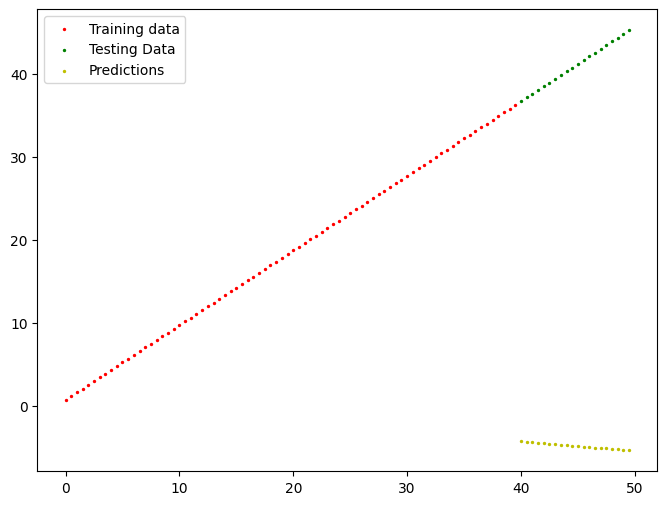

In [204]:
# Inference before training
with torch.inference_mode():    # context manager for inference
    y_pred_notrain = model_lr(X_test)

chart_data(predictions = y_pred_notrain.detach().numpy())

## Training and Testing

- Training: <br> 
`Take Input` -> `Forward Pass` -> `Calculate Loss` -> `Backward Propagation` -> `Gradient Descent`

- Testing: <br>
`Forward Pass` -> `Calculate Loss`

- epochs: One epoch goes through the entire training data once.

- Setting `optimizer.zero_grad()` is an **important part** of building pytorch models. Without this, gradients explode leading to bad results.

In [205]:
# Training loop

## Keeping track of important values
epoch_count = []
training_loss_values = []
testing_loss_values = []

## Setting epochs value
epochs = 100

for epoch in range(epochs):
    ### Training
    
    # Model to training mode
    model_lr.train()
    
    # Forward Pass
    y_pred = model_lr(X_train)
    
    # Calculate the Loss
    loss = loss_fn(y_pred, y_train) # prediction, target
    
    # Set optimizer to zero-grad (to flush the gradients of the parameters before backward)
        # Discussed further in torch-autograd-fs project in this github account
    optimizer.zero_grad()
    
    # Backward Propagation
    loss.backward()
    
    # Gradient Descent
    optimizer.step()
    
    ### Testing
    
    # Model to testing mode
    model_lr.eval()
    
    # Forward pass, loss calculation
    with torch.inference_mode():
        test_pred = model_lr(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 20 == 0:
        # Tracking progress
        epoch_count.append(epoch)
        training_loss_values.append(loss)
        testing_loss_values.append(test_loss)
        
        print(f"Epoch: {epoch}  |   Training Loss: {loss}   |   Testing Loss: {test_loss}")

Epoch: 0  |   Training Loss: 20.55611228942871   |   Testing Loss: 44.957977294921875
Epoch: 20  |   Training Loss: 12.734861373901367   |   Testing Loss: 27.261728286743164
Epoch: 40  |   Training Loss: 4.913612365722656   |   Testing Loss: 9.56547737121582
Epoch: 60  |   Training Loss: 0.22545747458934784   |   Testing Loss: 0.48845595121383667
Epoch: 80  |   Training Loss: 0.22233140468597412   |   Testing Loss: 0.48303890228271484


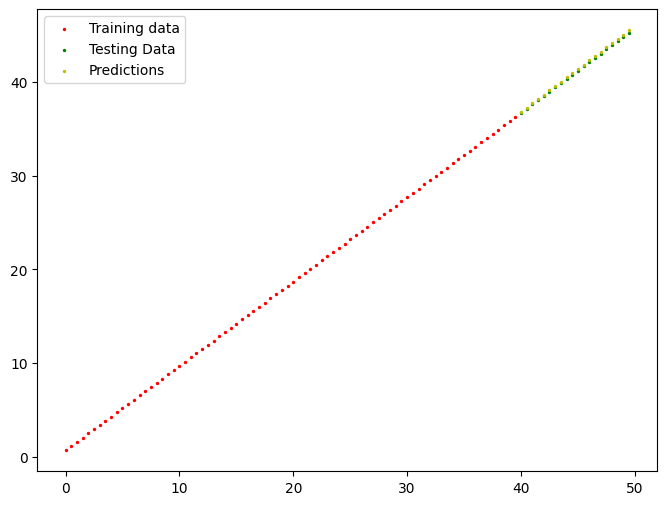

In [206]:
# Inference after training
with torch.inference_mode():
    y_pred = model_lr(X_test)

chart_data(predictions = y_pred.detach().numpy())

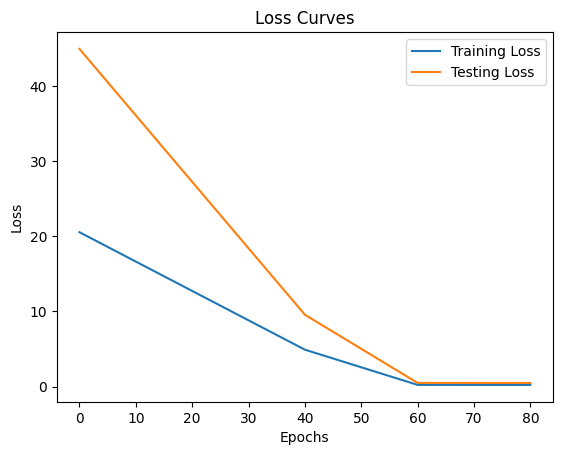

In [207]:
# Plotting loss curves
plt.plot(epoch_count, torch.Tensor(training_loss_values).numpy(), label = "Training Loss")
plt.plot(epoch_count, torch.Tensor(testing_loss_values).numpy(), label = "Testing Loss")
plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Saving and Loading the Model

- The functions `torch.save()` and `torch.load()` uses python pickle serialization.

- `nn.Module.load_state_dict()` - For loading the saved parameters of a model class.

In [208]:
# Saving the PyTorch Model
from pathlib import Path

## Directory
MODEL_DIR_PATH = Path('models')
MODEL_DIR_PATH.mkdir(parents = True, exist_ok = True)

## Model Name
MODEL_NAME = 'workflow_linear_regression_model.pth'
MODEL_SAVE_PATH = MODEL_DIR_PATH / MODEL_NAME

## Saving
print(f"Saving the model to {MODEL_SAVE_PATH}")
torch.save(obj = model_lr.state_dict(),
           f = MODEL_SAVE_PATH)

Saving the model to models/workflow_linear_regression_model.pth


In [209]:
# Loading the saved parameters of the model
model_lr_load = LinearRegressionModel()
model_lr_load.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_lr_load.state_dict()

/tmp/ipykernel_1127344/4109670567.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lr_load.load_state_dict(torch.load(MODEL_SAVE_PATH))


OrderedDict([('weights', tensor([0.9153])), ('bias', tensor([0.1915]))])

---

# Recap

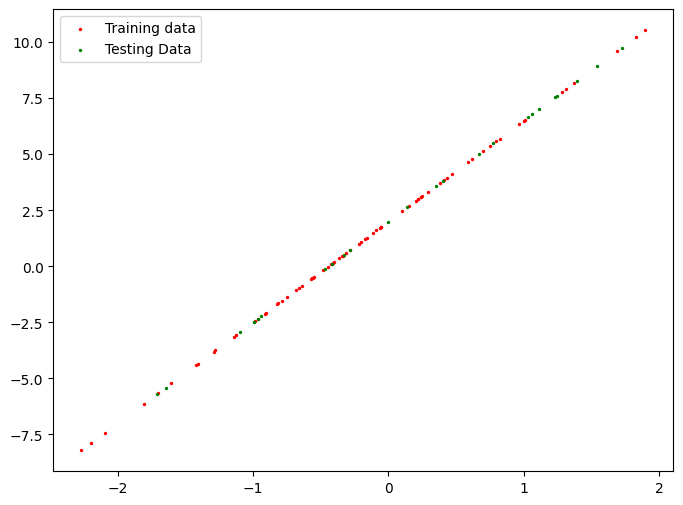

In [210]:
# Creating Data

## Model parameters
weight = 4.5
bias = 2

## Features and Labels
X = torch.randn(size = (100, 1))
y = weight * X + bias 

## Splitting data - train/test
ratio = 0.75
train_split = int(len(X) * ratio)

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

## Charting the data
chart_data(train_data=X_train,
           train_labels=y_train,
           test_data=X_test,
           test_labels=y_test)

In [211]:

# Creating the Model

## Model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1))
        self.bias = nn.Parameter(torch.randn(1))
        self.linear = nn.Linear(in_features = 1,
                           out_features = 1)
    
    def forward(self, x):
        return self.linear(x)

## Model instance
model_lr = LinearRegressionModel()

In [212]:
# Loss Function and Optimizer

## Loss function
loss_function = nn.L1Loss()
## Optimizer
optimizer = torch.optim.SGD(params = model_lr.parameters(),
                            lr = 0.05)

In [213]:
# Training and Testing Loop

## Saving checkpoints
epoch_count = []
training_loss_values = []
testing_loss_values = []

## epochs initialization
epochs = 250

## Looping
for epoch in range(epochs):
    ### Training Mode
    model_lr.train()
    
    # Forward Pass
    y_train_pred = model_lr(X_train)
    
    # Loss
    training_loss = loss_function(y_train_pred, y_train)
    
    # Set zero grad
    optimizer.zero_grad()
    
    # Back Propogation
    training_loss.backward()
    
    # Gradient Descent
    optimizer.step()
    
    ### Testing Mode
    model_lr.eval()
    
    # Forward Pass and Loss
    y_test_pred = model_lr(X_test)
    testing_loss = loss_function(y_test_pred, y_test)
    
    # Saving checkpoints, Progress update
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}  |   Training Loss: {training_loss}  |   Testing Loss: {testing_loss}")
        
        epoch_count.append(epoch)
        training_loss_values.append(training_loss)
        testing_loss_values.append(testing_loss_values)

Epoch: 0  |   Training Loss: 3.0139811038970947  |   Testing Loss: 3.9190289974212646
Epoch: 10  |   Training Loss: 2.7612874507904053  |   Testing Loss: 3.6056559085845947
Epoch: 20  |   Training Loss: 2.5132954120635986  |   Testing Loss: 3.2964179515838623
Epoch: 30  |   Training Loss: 2.273972272872925  |   Testing Loss: 2.9919497966766357
Epoch: 40  |   Training Loss: 2.0389814376831055  |   Testing Loss: 2.687894344329834
Epoch: 50  |   Training Loss: 1.8061578273773193  |   Testing Loss: 2.384392261505127
Epoch: 60  |   Training Loss: 1.57996666431427  |   Testing Loss: 2.084775447845459
Epoch: 70  |   Training Loss: 1.3558802604675293  |   Testing Loss: 1.7860225439071655
Epoch: 80  |   Training Loss: 1.1319646835327148  |   Testing Loss: 1.4872899055480957
Epoch: 90  |   Training Loss: 0.9089427590370178  |   Testing Loss: 1.188636302947998
Epoch: 100  |   Training Loss: 0.6859208941459656  |   Testing Loss: 0.8908852934837341
Epoch: 110  |   Training Loss: 0.4634815454483032 

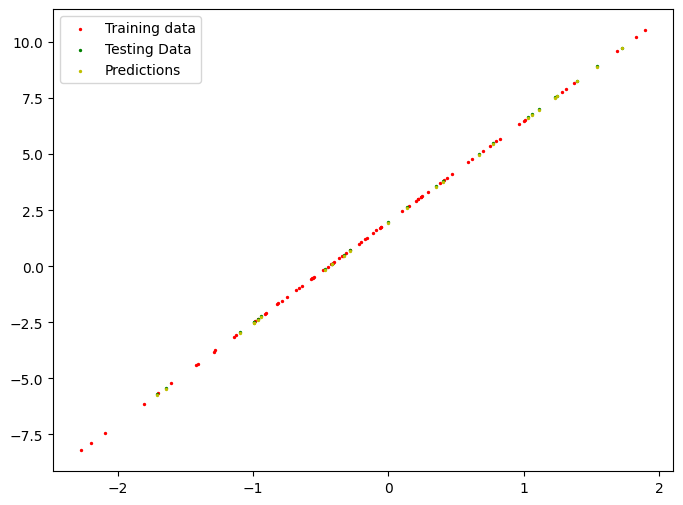

In [214]:
# Inference before training
with torch.inference_mode():    # context manager for inference
    y_pred = model_lr(X_test)

chart_data(train_data=X_train,
           train_labels=y_train,
           test_data=X_test,
           test_labels=y_test,
           predictions = y_pred)